In [1]:
from transformers import AutoTokenizer,AutoModelForTokenClassification
import torch
import re
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
df = pd.read_excel("data bert testing warning.xlsx")

In [3]:
df_neg = df[df['sentiment'] == 0]
df_pos = df[df['sentiment'] == 1]
print(f"negatif shape {df_neg.shape}")
print(f"postif shape {df_pos.shape}")
print(f"total shape {df.shape}")

negatif shape (28, 2)
postif shape (53, 2)
total shape (81, 2)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['berita'], df['sentiment'], test_size=0.33, random_state=42)

In [6]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

INFO:absl:Using C:\Users\PC\AppData\Local\Temp\tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4: 29.52MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4: 49.52MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4: 69.52MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4: 89.52MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4: 109.52MB
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_

In [7]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "saya membenci pos indonesia",
    "jne lebih baik dari pos indonesia"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.85544217, -0.32807323, -0.20317255, ..., -0.14749853,
        -0.6013241 ,  0.81510246],
       [-0.8813202 , -0.35912135, -0.3680412 , ..., -0.19175321,
        -0.58436674,  0.8337469 ]], dtype=float32)>

In [21]:
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

l = tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

model = tf.keras.Model(inputs=[text_input],outputs=[l])

In [22]:
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'pooled_output': (N 109482241   keras_layer[4][0]                
                                                                 keras_layer[4][1]                
                                                                 keras_layer[4][2]                
____________________________________________________________________________________________

In [23]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [24]:
model.fit(X_train,y_train,epochs=100)


Epoch 1/100
2/2 [==============================] - 6s 2s/step - loss: 0.7244 - accuracy: 0.4815 - precision: 0.6875 - recall: 0.3235
Epoch 2/100
2/2 [==============================] - 4s 2s/step - loss: 0.6983 - accuracy: 0.5741 - precision: 0.6122 - recall: 0.8824
Epoch 3/100
2/2 [==============================] - 4s 2s/step - loss: 0.6499 - accuracy: 0.6296 - precision: 0.6296 - recall: 1.0000

In [25]:
model.evaluate(X_test,y_test)


1/1 [==============================] - 3s 3s/step - loss: 0.6104 - accuracy: 0.6667 - precision: 0.6923 - recall: 0.9474


[0.6103606820106506, 0.6666666865348816, 0.692307710647583, 0.9473684430122375]

In [26]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [27]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5,1,0)
y_predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1])

Text(33.0, 0.5, 'Truth')

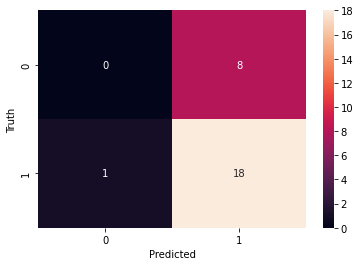

In [28]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_predicted)
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [29]:
print(classification_report(y_test,y_predicted))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.69      0.95      0.80        19

    accuracy                           0.67        27
   macro avg       0.35      0.47      0.40        27
weighted avg       0.49      0.67      0.56        27

